In [1]:
import numpy as np
import scipy as sp
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
class MPC:
    def __init__(self, N=25, dt=0.01, Lf=2.67):
        self.N = N
        self.dt = dt
        self.Lf = Lf
        self.graph = None
    #---------------------------------------------------------------------------    
    def tf_polyeval(self, coeffs, x):
        # Numpy.polyfit's coeffs are ordered highest power first (unlike C++ Eigen's)
        fx = 0.0
        for i, c in enumerate(coeffs):
            fx += c*tf.pow(x, len(coeffs) - i - 1)
        return fx
    def build_graph(self, coeffs):
        N = self.N
        dt = self.dt
        Lf = self.Lf
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.state_t = tf.placeholder(dtype = tf.float32, shape=[6])
            self.x_t = [tf.gather(self.state_t, 0)]
            self.y_t = [tf.gather(self.state_t, 1)]
            self.psi_t = [tf.gather(self.state_t, 2)]
            self.v_t = [tf.gather(self.state_t, 3)]
            self.cte_t = [tf.gather(self.state_t, 4)]
            self.epsi_t = [tf.gather(self.state_t, 5)]
            self.a_t = tf.Variable(np.random.normal(0.0, scale=1, size=N), dtype=tf.float32)
            self.delta_t = tf.Variable(np.random.normal(0.0, scale=1, size=N), dtype=tf.float32)
            self.loss_t = 0.0
            for i in range(1, N):
                self.x_t.append(self.x_t[i-1] + self.v_t[i-1] * tf.cos(self.psi_t[i-1]) * dt)
                self.y_t.append(self.y_t[i-1] + self.v_t[i-1] * tf.sin(self.psi_t[i-1]) * dt)
                self.psi_t.append(self.psi_t[i-1] + self.v_t[i-1] * self.delta_t[i-1]/Lf * dt)
                self.v_t.append(self.v_t[i-1] + self.a_t[i-1] * dt)
                self.f0_t = self.tf_polyeval(coeffs, self.x_t[i-1]) 
                self.psides0_t = tf.atan(coeffs[0])
                self.cte_t.append(self.f0_t - self.y_t[i-1] + self.v_t[i-1] * tf.sin(self.epsi_t[i-1]) * dt)
                self.epsi_t.append(self.psi_t[i-1] - self.psides0_t + self.v_t[i-1] * self.delta_t[i-1]/Lf * dt)
                self.loss_t += (tf.square(self.cte_t[i-1])        # CTE loss
                                + tf.square(self.epsi_t[i-1])     # Direction loss
                                + tf.square(self.v_t[i-1]-40.0) # Speed loss (prevent car from stopping)
                                + tf.square(self.a_t[i-1])        # minimize use of throttle
                                + tf.square(self.delta_t[i-1]))    # minimize use of steering
            
            # change throttle/steering angle smoothly
            for i in range(0, N-2): 
                self.loss_t += (tf.square(tf.gather(self.delta_t, i+1) 
                                          - tf.gather(self.delta_t, i))
                                + tf.square(tf.gather(self.a_t, i+1) 
                                              - tf.gather(self.a_t, i)))
            a_lb = np.ones(N)*-1.0
            a_ub = np.ones(N)
            dlt_lb = np.ones(N)*(-0.436332) # -25 degrees in rad
            dlt_ub = np.ones(N)*(0.436332)  # 25 degrees in rad
            self.opt = tf.contrib.opt.ScipyOptimizerInterface(self.loss_t, 
                                                         var_to_bounds={self.a_t:[a_lb, a_ub], 
                                                                        self.delta_t:[dlt_lb, dlt_ub]})
            self.init_op = tf.global_variables_initializer()
    #---------------------------------------------------------------------------
    def solve(self, state, coeffs):
        if self.graph is None:
            self.build_graph(coeffs)
            self.sess = tf.Session(graph = self.graph)
            # I am giong to initialize now
            self.sess.run(self.init_op)
            
        self.opt.minimize(self.sess, feed_dict={self.state_t: state})
        ops_list = [self.x_t, self.y_t, self.psi_t, self.v_t, self.cte_t, self.epsi_t]
        next_states = self.sess.run(ops_list, feed_dict={self.state_t:state})
        x, y, psi, v, cte, epsi = next_states
        next_state = np.array([x[1], y[1], psi[1], v[1], cte[1], epsi[1]], dtype=np.float32)
        
        opt_actuators = self.sess.run([self.a_t, self.delta_t], feed_dict={self.state_t:state})
        return [next_state, opt_actuators]

In [3]:
ptsx = np.array([-100, 100.])
ptsy = np.array([-1, -1])

coeffs = np.polyfit(ptsx, ptsy, deg=1)

x_init = -1.0
y_init = 10.0
psi_init = 0.0
v_init = 10.0

cte_init = np.polyval(coeffs, x_init) - y_init
epsi_init = psi_init - np.arctan(coeffs[0])

x_vals = [x_init]
y_vals = [y_init]
psi_vals = [psi_init]
v_vals = [v_init]
cte_vals = [cte_init]
a_vals = []
delta_vals = []

state = np.array([x_init, y_init, psi_init, v_init, cte_init, epsi_init], dtype=np.float32)

In [4]:
mpc = MPC(N = 25, dt=0.01)
for iteration in range(500):
    state, opt_actuators = mpc.solve(state, coeffs=coeffs.astype(np.float32))

    x_vals.append(state[0])
    y_vals.append(state[1])
    psi_vals.append(state[2])
    v_vals.append(state[3])
    cte_vals.append(state[4])

    a_vals.append(opt_actuators[0][0])
    delta_vals.append(opt_actuators[1][0])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 24311.199219
  Number of iterations: 8
  Number of functions evaluations: 10
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 14908.492188
  Number of iterations: 1
  Number of functions evaluations: 14
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 14896.539062
  Number of iterations: 1
  Number of functions evaluations: 14


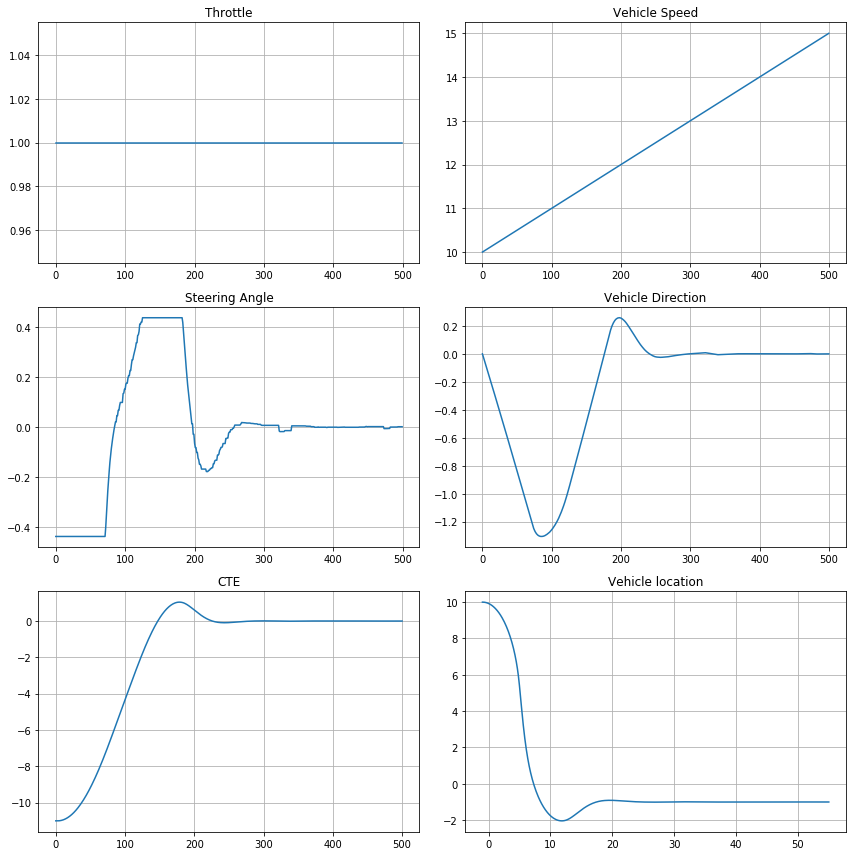

In [5]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(12, 12)
ax_i = 0
ax = ax.flatten()

ax[0].plot(a_vals)
ax[0].title.set_text("Throttle")
ax[0].grid()

ax[1].plot(v_vals)
ax[1].title.set_text("Vehicle Speed")
ax[1].grid()

ax[2].plot(delta_vals)
ax[2].title.set_text("Steering Angle")
#ax[2].set_ylim([-1, .2])
ax[2].grid()

ax[3].plot(psi_vals)
ax[3].title.set_text("Vehicle Direction")
ax[3].grid()

ax[4].plot(cte_vals)
ax[4].title.set_text("CTE")
ax[4].grid()

#ax[5].scatter(x_vals, y_vals)
ax[5].plot(x_vals, y_vals)
ax[5].title.set_text("Vehicle location")
ax[5].grid()

fig.tight_layout()
plt.show()